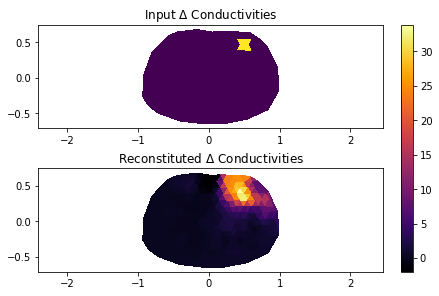

In [66]:
from __future__ import division, absolute_import, print_function

import numpy as np
import matplotlib.pyplot as plt

#Creates mesh background
import pyeit.mesh as mesh


from pyeit.eit.fem import Forward
from pyeit.eit.utils import eit_scan_lines
from pyeit.mesh.shape import thorax
import pyeit.eit.bp as bp

""" 0. build mesh """
# Mesh shape is specified with fd parameter in the instantiation, e.g : fd=thorax , Default :fd=circle
mesh_obj, el_pos = mesh.create(16, h0 = 0.1, fd=thorax)

# extract node, element, alpha
pts = mesh_obj["node"]
tri = mesh_obj["element"]

""" 1. problem setup """
anomaly = [{"x": 0.5, "y": 0.5, "d": 0.1, "perm": 10.0}]
mesh_new = mesh.set_perm(mesh_obj, anomaly = anomaly, background=1.0)

# draw
fig, axes = plt.subplots(2, 1, constrained_layout = True)
fig.set_size_inches(6, 4)

ax = axes[0]
ax.axis("equal")
ax.set_title(r"Input $\Delta$ Conductivities")

delta_perm = np.real(mesh_new["perm"] - mesh_obj["perm"])
im = ax.tripcolor(
    pts[:, 0], pts[:, 1], tri, delta_perm, shading="flat", cmap=plt.cm.viridis
)
# fig.savefig('demo_bp_0.png', dpi=96)

""" 2. FEM forward simulations """
# setup EIT scan conditions
# adjacent stimulation (el_dist=1), adjacent measures (step=1)
el_dist, step = 1, 1
ex_mat = eit_scan_lines(16, el_dist)

# calculate simulated data
fwd = Forward(mesh_obj, el_pos)
f0 = fwd.solve_eit(ex_mat, step=step, perm=mesh_obj["perm"])
f1 = fwd.solve_eit(ex_mat, step=step, perm=mesh_new["perm"])

"""
3. naive inverse solver using back-projection
"""
eit = bp.BP(mesh_obj, el_pos, ex_mat=ex_mat, step=1, parser="std")
eit.setup(weight="none")
ds = 192.0 * eit.solve(f1.v, f0.v, normalize=False)

# plot
ax1 = axes[1]
im = ax1.tripcolor(pts[:, 0], pts[:, 1], tri, ds, cmap=plt.cm.inferno)
ax1.set_title(r"Reconstituted $\Delta$ Conductivities")
ax1.axis("equal")
fig.colorbar(im, ax=axes.ravel().tolist())
""" for production figures, use dpi=300 or render pdf """
# fig.savefig('../doc/images/demo_bp.png', dpi=96)
plt.show()

In [2]:
import os
import SimpleITK as sitk
import torch

os.chdir('C:/Users/Renan/Desktop/dsai-thesis')

conduct = sitk.ReadImage('TR700.nii')
conduct = sitk.GetArrayFromImage(conduct)
conduct = torch.tensor(conduct)

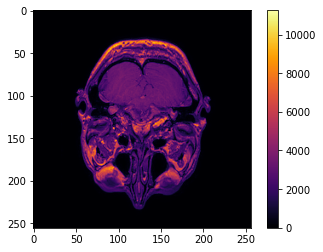

In [12]:
import matplotlib.pyplot as plt
plt.imshow(conduct[10, :, :], cmap = 'inferno')
plt.colorbar()

In [77]:
""" 0. construct mesh structure """
mesh_obj, el_pos = mesh.create(16, h0=0.08, fd = shape.ball)

# extract node, element, permittivity
pts = mesh_obj["node"]
tri = mesh_obj["element"]

""" 1. problem setup """
# test function for altering the permittivity in mesh
anomaly = [
    {"x": 0.4, "y": 0, "d": 0.1, "perm": 5},
    {"x": -0.4, "y": 0, "d": 0.1, "perm": 5},
    {"x": 0, "y": 0.5, "d": 0.1, "perm": 0.1},
    {"x": 0, "y": -0.5, "d": 0.1, "perm": 0.1},
]
mesh_new = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)
delta_perm = np.real(mesh_new["perm"] - mesh_obj["perm"])

""" ax1. FEM forward simulations """
# setup EIT scan conditions
el_dist, step = 1, 1
ex_mat = eit_scan_lines(16, el_dist)

# calculate simulated data
fwd = Forward(mesh_obj, el_pos)
f0 = fwd.solve_eit(ex_mat, step=step, perm=mesh_obj["perm"])
f1 = fwd.solve_eit(ex_mat, step=step, perm=mesh_new["perm"])

""" ax2. BP """
eit = bp.BP(mesh_obj, el_pos, ex_mat=ex_mat, step=1, parser="std")
eit.setup(weight="none")
ds = eit.solve(f1.v, f0.v, normalize=True)
ds_bp = ds

""" ax3. JAC """
eit = jac.JAC(mesh_obj, el_pos, ex_mat=ex_mat, step=step, perm=1.0, parser="std")
# parameter tuning is needed for better EIT images
eit.setup(p=0.5, lamb=0.1, method="kotre")
# if the jacobian is not normalized, data may not to be normalized too.
ds = eit.solve(f1.v, f0.v, normalize=False)
ds_jac = sim2pts(pts, tri, ds)

""" ax4. GREIT """
eit = greit.GREIT(mesh_obj, el_pos, ex_mat=ex_mat, step=step, parser="std")
# parameter tuning is needed for better EIT images
eit.setup(p=0.5, lamb=0.01)
ds = eit.solve(f1.v, f0.v, normalize=False)
x, y, ds_greit = eit.mask_value(ds, mask_value=np.NAN)

""" build for EIT2016b (orig: 300p x 300p, 150dpi) """
size = (8, 6)
axis_size = [-1.2, 1.2, -1.2, 1.2]
im_size = [-2, 34, -2, 34]
fig = plt.figure(figsize=size)
gs = gridspec.GridSpec(2, 2)

# simulation
pmax = np.max(np.abs(delta_perm))
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    delta_perm,
    shading="flat",
    cmap=plt.cm.RdBu,
    vmin=-pmax,
    vmax=pmax,
)
ax1.set_title(r"(a) $\Delta$ Conductivity")
ax1.axis(axis_size)
ax1.set_aspect("equal")
fig.colorbar(im1)
ax1.axis("off")

# Filtered BP
bp_max = np.max(np.abs(ds_bp))
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    np.real(ds_bp),
    cmap=plt.cm.RdBu,
    vmin=-bp_max,
    vmax=bp_max,
)
ax2.set_title(r"(b) BP")
ax2.axis(axis_size)
ax2.set_aspect("equal")
fig.colorbar(im2)
ax2.axis("off")

# JAC
jac_max = np.max(np.abs(ds_jac))
ax3 = fig.add_subplot(gs[1, 0])
im3 = ax3.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    np.real(ds_jac),
    cmap=plt.cm.RdBu,
    vmin=-jac_max,
    vmax=jac_max,
)
ax3.set_title(r"(c) JAC")
ax3.axis(axis_size)
ax3.set_aspect("equal")
fig.colorbar(im3)
ax3.axis("off")

# GREIT
gr_max = np.max(np.abs(ds_greit))
ax4 = fig.add_subplot(gs[1, 1])
im4 = ax4.imshow(
    np.real(ds_greit),
    interpolation="nearest",
    cmap=plt.cm.RdBu,
    vmin=-gr_max,
    vmax=gr_max,
)
ax4.set_title(r"(d) GREIT")
ax4.axis(im_size)
ax4.set_aspect("equal")
fig.colorbar(im4)
ax4.axis("off")

# save
plt.show()
# fig.tight_layout()
# fig.subplots_adjust(top=0.875, bottom=0.01)
# fig.set_size_inches(1, 1)
# fig.savefig('eit2016b.png', dpi=300)

KeyboardInterrupt: 

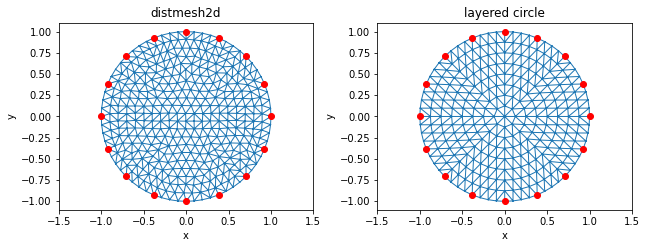

In [26]:
from __future__ import division, absolute_import, print_function
import matplotlib.pyplot as plt

from pyeit.mesh import create
from pyeit.mesh import layer_circle
mesh0, el_pos0 = create(n_el=16)
mesh1, el_pos1 = layer_circle(n_el=16, n_fan=8, n_layer=8)

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# plot mesh0: distmesh
p = mesh0["node"]
t = mesh0["element"]
ax1.triplot(p[:, 0], p[:, 1], t, lw=1)
ax1.plot(p[el_pos0, 0], p[el_pos0, 1], "ro")
ax1.set_aspect("equal")
ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1.1, 1.1])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("distmesh2d")

# plot mesh1: layer circle
p = mesh1["node"]
t = mesh1["element"]
ax2.triplot(p[:, 0], p[:, 1], t, lw=1)
ax2.plot(p[el_pos1, 0], p[el_pos1, 1], "ro")
ax2.set_aspect("equal")
ax2.set_xlim([-1.5, 1.5])
ax2.set_ylim([-1.1, 1.1])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("layered circle")

fig.tight_layout()
fig.subplots_adjust(top=0.975, bottom=0.015)
# fig.set_size_inches(1, 1)
fig.savefig("figure01.pdf", dpi=300)
plt.show()

mesh status:
1476 nodes, 2821 elements
std (ex_dist=1) = 0.225619
std (ex_dist=2) = 0.189920
std (ex_dist=5) = 0.175197
std (ex_dist=8) = 0.165959


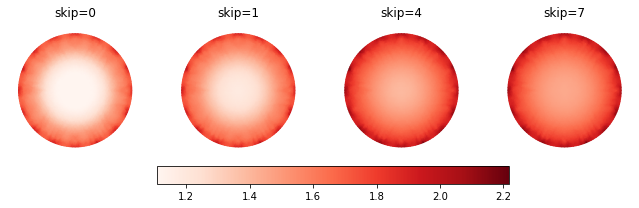

In [28]:
from __future__ import division, absolute_import, print_function

# numeric
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# pyEIT
import pyeit.mesh as mesh
from pyeit.eit.interp2d import tri_area, sim2pts
from pyeit.mesh import quality
from pyeit.eit.fem import Forward
from pyeit.eit.utils import eit_scan_lines

""" 0. build mesh """
# mesh_obj, el_pos = mesh.layer_circle(n_layer=8, n_fan=6)
mesh_obj, el_pos = mesh.create(h0=0.05)

# extract node, element, alpha
pts = mesh_obj["node"]
tri = mesh_obj["element"]
x, y = pts[:, 0], pts[:, 1]
quality.stats(pts, tri)


def calc_sens(fwd, ex_mat):
    """
    see Adler2017 on IEEE TBME, pp 5, figure 6,
    Electrical Impedance Tomography: Tissue Properties to Image Measures
    """
    # solving EIT problem
    p = fwd.solve_eit(ex_mat=ex_mat, parser="fmmu")
    v0 = p.v
    # normalized jacobian (note: normalize affect sensitivity)
    v0 = v0[:, np.newaxis]
    jac = p.jac  # / v0
    # calculate sensitivity matrix
    s = np.linalg.norm(jac, axis=0)
    ae = tri_area(pts, tri)
    s = np.sqrt(s) / ae
    assert any(s >= 0)

    se = np.log10(s)
    sn = sim2pts(pts, tri, se)
    return sn


""" 1. FEM forward setup """
# calculate simulated data using FEM
fwd = Forward(mesh_obj, el_pos)
# loop over EIT scan settings: vary the distance of stimulation nodes, AB
ex_list = [1, 2, 5, 8]
N = len(ex_list)
s = []
for ex_dist in ex_list:
    ex_mat = eit_scan_lines(16, ex_dist)
    # TODO: ex_mat can also be stacked, see eit_dynamic_stack.py
    s0 = calc_sens(fwd, ex_mat)
    s.append(s0)

""" 2. Plot (elements) sensitivity """
vmax = np.max(s)
# vmin = np.min(s)
vmin = vmax - vmax * 0.5
fig = plt.figure(figsize=(9, 3))
gs = gridspec.GridSpec(1, N)
ax_array = []
for ix in range(N):
    ax = fig.add_subplot(gs[0, ix])
    ax_array.append(ax)
    sn = s[ix]
    ex_dist = ex_list[ix]
    # statistics, it seems like ex_dist=4 yields the minimal std
    std = np.std(sn)
    print("std (ex_dist=%d) = %f" % (ex_dist, std))
    im = ax.tripcolor(
        x,
        y,
        tri,
        sn,
        edgecolors="none",
        shading="gouraud",
        cmap=plt.cm.Reds,
        antialiased=True,
        vmin=vmin,
        vmax=vmax,
    )
    # annotate
    ax.set_title("skip=" + str(ex_dist - 1))
    ax.set_aspect("equal")
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlim([-1.2, 1.2])
    ax.axis("off")

plt.colorbar(im, ax=ax_array, orientation="horizontal", shrink=0.7)

# fig.savefig('demo_sens.png', dpi=96)
# fig.set_size_inches(5, 5)
# fig.tight_layout()
fig.subplots_adjust(top=0.975, bottom=0.275, left=0.01, right=0.975)
fig.savefig("figure02b.pdf", dpi=300)
plt.show()

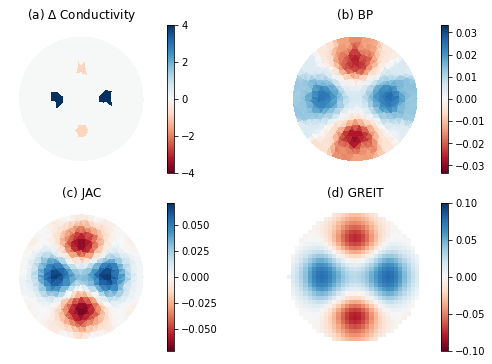

In [29]:
from __future__ import division, absolute_import, print_function

import numpy as np
import matplotlib.pyplot as plt

# import matplotlib
# matplotlib.rcParams.update({'font.size': 3})
import matplotlib.gridspec as gridspec

# pyEIT 2D algorithm modules
import pyeit.mesh as mesh
from pyeit.eit.fem import Forward
from pyeit.eit.interp2d import sim2pts
from pyeit.eit.utils import eit_scan_lines

import pyeit.eit.greit as greit
import pyeit.eit.bp as bp
import pyeit.eit.jac as jac

""" 0. construct mesh structure """
mesh_obj, el_pos = mesh.create(16, h0=0.1)

# extract node, element, permittivity
pts = mesh_obj["node"]
tri = mesh_obj["element"]

""" 1. problem setup """
# test function for altering the permittivity in mesh
anomaly = [
    {"x": 0.4, "y": 0, "d": 0.1, "perm": 5},
    {"x": -0.4, "y": 0, "d": 0.1, "perm": 5},
    {"x": 0, "y": 0.5, "d": 0.1, "perm": 0.1},
    {"x": 0, "y": -0.5, "d": 0.1, "perm": 0.1},
]
mesh_new = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)
delta_perm = np.real(mesh_new["perm"] - mesh_obj["perm"])

""" ax1. FEM forward simulations """
# setup EIT scan conditions
el_dist, step = 1, 1
ex_mat = eit_scan_lines(16, el_dist)

# calculate simulated data
fwd = Forward(mesh_obj, el_pos)
f0 = fwd.solve_eit(ex_mat, step=step, perm=mesh_obj["perm"])
f1 = fwd.solve_eit(ex_mat, step=step, perm=mesh_new["perm"])

""" ax2. BP """
eit = bp.BP(mesh_obj, el_pos, ex_mat=ex_mat, step=1, parser="std")
eit.setup(weight="None")
ds = eit.solve(f1.v, f0.v, normalize=True)
ds_bp = ds

""" ax3. JAC """
eit = jac.JAC(mesh_obj, el_pos, ex_mat=ex_mat, step=step, perm=1.0, parser="std")
# parameter tuning is needed for better EIT images
eit.setup(p=0.5, lamb=0.1, method="kotre")
# if the jacobian is not normalized, data may not to be normalized too.
ds = eit.solve(f1.v, f0.v, normalize=False)
ds_jac = sim2pts(pts, tri, ds)

""" ax4. GREIT """
eit = greit.GREIT(mesh_obj, el_pos, ex_mat=ex_mat, step=step, parser="std")
# parameter tuning is needed for better EIT images
eit.setup(p=0.5, lamb=0.01)
ds = eit.solve(f1.v, f0.v, normalize=False)
x, y, ds_greit = eit.mask_value(ds, mask_value=np.NAN)

""" build figure """
size = (9, 6)
axis_size = [-1.2, 1.2, -1.2, 1.2]
im_size = [-2, 34, -2, 34]
fig = plt.figure(figsize=size)
gs = gridspec.GridSpec(2, 2)

# simulation
pmax = np.max(np.abs(delta_perm))
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    delta_perm,
    shading="flat",
    cmap=plt.cm.RdBu,
    vmin=-pmax,
    vmax=pmax,
)
ax1.set_title(r"(a) $\Delta$ Conductivity")
ax1.axis(axis_size)
ax1.set_aspect("equal")
fig.colorbar(im1)
ax1.axis("off")

# Filtered BP
bp_max = np.max(np.abs(ds_bp))
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    np.real(ds_bp),
    cmap=plt.cm.RdBu,
    vmin=-bp_max,
    vmax=bp_max,
)
ax2.set_title(r"(b) BP")
ax2.axis(axis_size)
ax2.set_aspect("equal")
fig.colorbar(im2)
ax2.axis("off")

# JAC
jac_max = np.max(np.abs(ds_jac))
ax3 = fig.add_subplot(gs[1, 0])
im3 = ax3.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    np.real(ds_jac),
    cmap=plt.cm.RdBu,
    vmin=-jac_max,
    vmax=jac_max,
)
ax3.set_title(r"(c) JAC")
ax3.axis(axis_size)
ax3.set_aspect("equal")
fig.colorbar(im3)
ax3.axis("off")

# GREIT
gr_max = np.max(np.abs(ds_greit))
ax4 = fig.add_subplot(gs[1, 1])
im4 = ax4.imshow(
    np.real(ds_greit),
    interpolation="nearest",
    cmap=plt.cm.RdBu,
    vmin=-gr_max,
    vmax=gr_max,
)
ax4.set_title(r"(d) GREIT")
ax4.axis(im_size)
ax4.set_aspect("equal")
fig.colorbar(im4)
ax4.axis("off")

# save
plt.show()
fig.tight_layout()
# fig.subplots_adjust(top=0.9, bottom=0.025)
# fig.set_size_inches(1, 1)
fig.savefig("figure03.pdf", dpi=300)

iter = 0, lamb = 1.000000, gtol = 0.003792
iter = 1, lamb = 0.100000, gtol = 0.033309
iter = 2, lamb = 0.010000, gtol = 0.166428
iter = 3, lamb = 0.001000, gtol = 0.332155
iter = 4, lamb = 0.000100, gtol = 0.390948
iter = 5, lamb = 0.000010, gtol = 0.410009
iter = 6, lamb = 0.000010, gtol = 0.182680
iter = 7, lamb = 0.000010, gtol = 0.122572
iter = 8, lamb = 0.000010, gtol = 0.078884
iter = 9, lamb = 0.000010, gtol = 0.057773
iter = 10, lamb = 0.000010, gtol = 0.045032
iter = 11, lamb = 0.000010, gtol = 0.037897
iter = 12, lamb = 0.000010, gtol = 0.030939
iter = 13, lamb = 0.000010, gtol = 0.026157
iter = 14, lamb = 0.000010, gtol = 0.022505
iter = 15, lamb = 0.000010, gtol = 0.019634
iter = 16, lamb = 0.000010, gtol = 0.017329
iter = 17, lamb = 0.000010, gtol = 0.015428
iter = 18, lamb = 0.000010, gtol = 0.013842
iter = 19, lamb = 0.000010, gtol = 0.012523


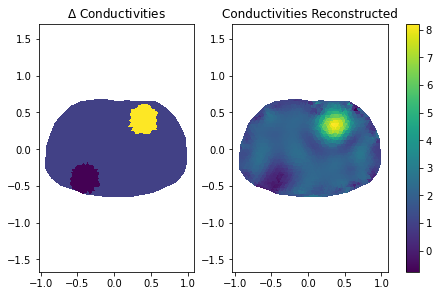

In [30]:
from __future__ import division, absolute_import, print_function

import numpy as np
import matplotlib.pyplot as plt

# pyEIT 2D algorithms modules
from pyeit.mesh import create, set_perm
from pyeit.eit.fem import Forward
from pyeit.eit.utils import eit_scan_lines
from pyeit.mesh.shape import thorax
import pyeit.eit.jac as jac

""" 1. setup """
n_el = 16
# Mesh shape is specified with fd parameter in the instantiation, e.g : fd=thorax , Default :fd=circle
mesh_obj, el_pos = create(n_el, h0=0.05, fd=thorax)
# test function for altering the permittivity in mesh
anomaly = [
    {"x": 0.4, "y": 0.4, "d": 0.2, "perm": 10},
    {"x": -0.4, "y": -0.4, "d": 0.2, "perm": 0.1},
]
# background changed to values other than 1.0 requires more iterations
mesh_new = set_perm(mesh_obj, anomaly=anomaly, background=2.0)

# extract node, element, perm
pts = mesh_obj["node"]
tri = mesh_obj["element"]
perm = mesh_new["perm"]

# show
fig, axes = plt.subplots(1, 2, constrained_layout=True)
fig.set_size_inches(6, 4)

ax = axes[0]
im = ax.tripcolor(
    pts[:, 0], pts[:, 1], tri, np.real(perm), shading="flat", cmap=plt.cm.viridis
)
ax.axis("equal")
ax.set_title(r"$\Delta$ Conductivities")

""" 2. calculate simulated data """
el_dist, step = 1, 1
ex_mat = eit_scan_lines(n_el, el_dist)
fwd = Forward(mesh_obj, el_pos)
f1 = fwd.solve_eit(ex_mat, step, perm=mesh_new["perm"], parser="std")

""" 3. solve_eit using gaussian-newton (with regularization) """
# number of stimulation lines/patterns
eit = jac.JAC(mesh_obj, el_pos, ex_mat, step, perm=1.0, parser="std")
eit.setup(p=0.25, lamb=1.0, method="lm")
# lamb = lamb * lamb_decay
ds = eit.gn(f1.v, lamb_decay=0.1, lamb_min=1e-5, maxiter=20, verbose=True)

# plot
ax = axes[1]
im = ax.tripcolor(
    pts[:, 0],
    pts[:, 1],
    tri,
    np.real(ds),
    shading="flat",
    alpha=1.0,
    cmap=plt.cm.viridis,
)
ax.axis("equal")
ax.set_title("Conductivities Reconstructed")

fig.colorbar(im, ax=axes.ravel().tolist())
# fig.savefig('../doc/images/demo_static.png', dpi=96)
plt.show()

In [8]:
import torch
import torch.nn as nn

sample = torch.rand(1, 256, 256, 192)

In [7]:
import nibabel as nib 
import os 
import SimpleITK as sitk
import numpy as np
from numpy import pi, exp, sqrt
import warnings
import cv2
import scipy.ndimage
import math

warnings.filterwarnings('ignore')

def load_image_nib(image_file_path):
    return np.array(nib.load(image_file_path).get_fdata())

directory = 'C:/Users/Renan/Desktop/dsai-thesis/data_simon/SIMON_BIDS/sub-032633/ses-012/anat'
filename = 'sub-032633_ses-012_run-1_T1w.nii.gz'

# directory = './CTI'
# filename1, filename2 = 'TR700.nii', 'TR3000.nii'


h1dr, h2dr = nib.load(os.path.join(directory, filename)), nib.load(os.path.join(directory, filename))
v1, v2 = h1dr.get_data(), h2dr.get_data()
h1dr_header, h2dr_header = h1dr.header['scl_slope'], h2dr.header['scl_slope']
im1, im2 = v1, v2
slices = im1.shape[0]
#------------------------------------------------#
#                MODEL COEFFICIENTS              #
#------------------------------------------------#
sliceToShow = 100
c1, c2, c3 = 0.286, 1.526e-05, 11.852
w1, w2 = 1.525, 1.443
CondRange, WaterRange, InstensRange = range(0, 2), range(60, 100), range(100, 1400)

#------------------------------------------------------#
#    Get ROI mask to identify the object of interest   #
#------------------------------------------------------#

porcenThld = 0.03
tmp1x = np.abs(im2)
RegionInterest = np.ones(tmp1x.shape)
tmp2x = tmp1x

def fspecial_gauss(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

def matlab_style_gauss2D(shape=(3, 3), sigma = 0.5):
    '''
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    '''
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2. * sigma * sigma) )
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

for slice in np.arange(0, slices).reshape(-1):
    tmp1 = cv2.medianBlur(tmp1x[slice, :, :], 1)
    s, k = 1, 2 
    probs = [exp(-z * z/(2 * s * s))/sqrt(2 * pi * s * s) for z in range(-k, k + 1)] 
    # H = np.outer(probs, probs)
    H = matlab_style_gauss2D()
    tmp1 = scipy.ndimage.convolve(tmp1, H, mode = 'nearest')
    tmp1x[slice, :, :] = tmp1x[slice, :, :] / np.amax(np.amax(tmp1x))
    tmp2x[slice, :, :] = tmp1 / np.amax(tmp1)

Thld = np.amax(np.abs(tmp2x)) * porcenThld
RegionInterest[np.abs(tmp1x) <= Thld] = 0
obj_v = [RegionInterest == 1]

#----------------------------#
#    Spin Echo image ratio   #
#----------------------------#

ImRatio = np.abs(im1 / im2)
ImRatio[np.isnan(ImRatio)] = 0
ImRatio[np.isinf(ImRatio)] = 0
Ir = ImRatio
IrC = np.abs(np.multiply((Ir), RegionInterest))

#----------------#
#    Water map   #
#----------------#

IW = np.multiply(w1, np.exp(np.multiply(-w2, IrC)))
IW = np.abs(np.multiply(IW, RegionInterest))
v1 = np.abs(np.multiply(IW, RegionInterest) * 10000)
IW[IW > 1] = 1
v1 = np.abs(np.multiply(IW, RegionInterest) * 10000)


#-----------------------#
#    Conductivity map   #
#-----------------------#

ImCond = (c1 + np.multiply(c2, np.exp(np.multiply(c3, IW))))
ROIept = IW
ROIept[ROIept != 0] = 1
v1 = np.abs(np.multiply(ImCond, ROIept) * 10000)
ImCond = np.multiply(ImCond, ROIept)


Text(0.5, 1.0, 'Conductivity (S/m) at Slice 100')

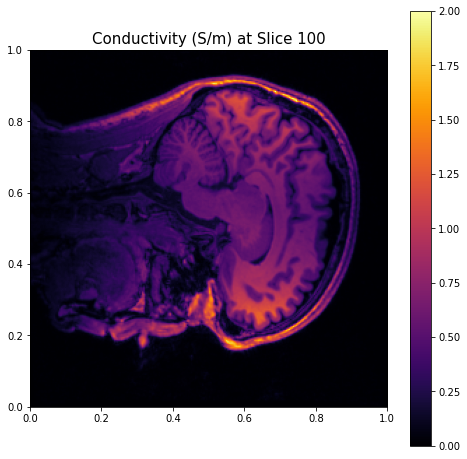

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8))
plt.imshow(tmp1x[sliceToShow, :, :] + tmp2x[sliceToShow, :, :], extent = [0, 1, 0, 1], cmap = 'inferno')
plt.colorbar()
# plt.clim(0, 1.2)
plt.title(f'Conductivity (S/m) at Slice {sliceToShow}', size = 15)

In [18]:
import torch 
tmp1x = torch.tensor(tmp1x)
tmp1x = tmp1x.unsqueeze(0)
tmp1x.shape

torch.Size([1, 180, 256, 256])

In [23]:
import nibabel as nib 
import os 
import SimpleITK as sitk
import numpy as np
from numpy import pi, exp, sqrt
import warnings
import cv2
import scipy.ndimage
import math
import torch


def split_init():
    os.chdir('C:/Users/Renan/Desktop/dsai-thesis')
    directory = 'data_simon/SIMON_BIDS/sub-032633'
    FOLDERS = []
    FOLDERS_PATH = []
    COMPLETE_DATA = []
    COMPLETE_PATH = []

    for folder in os.listdir(directory):
        FOLDERS.append(folder)
        FOLDERS_PATH.append(os.path.join(directory, folder))

    for folder in FOLDERS_PATH:
        if len(os.listdir(folder)) > 1:
            path = os.path.join(folder, 'anat')
            ITEMS = []
            for item in os.listdir(path):
                ITEMS.append(item)
                for item in ITEMS:
                    if item.endswith('T2star.nii.gz'):
                        COMPLETE_DATA.append(folder)
    COMPLETE_DATA = list(set(COMPLETE_DATA))                 
    for complete in COMPLETE_DATA:
        COMPLETE_PATH.append(os.path.join(complete, 'anat'))

    T1W_FILES = []
    T2W_FILES = []
    T2STAR_FILES = []
    for folder in COMPLETE_PATH:
        for items in os.listdir(folder):
            if items.endswith('run-1_T1w.nii.gz') and not items.endswith('acq-10iso_run-1_T1w.nii.gz'):
                T1W_FILES.append(items)
            elif items.endswith('run-1_T2w.nii.gz'):
                T2W_FILES.append(items)
            elif items.endswith('run-1_T2star.nii.gz') and not items.endswith('acq-ph_run-1_T2star.nii.gz') and not items.endswith('acq-pmri_run-1_T2star.nii.gz'):
                T2STAR_FILES.append(items)

    T1W_PATH, T2W_PATH, T2STAR_PATH = [], [], []
    for T1W, T2W, T2STAR, complete in zip(T1W_FILES, T2W_FILES, T2STAR_FILES, COMPLETE_DATA):
        T1W_PATH.append(os.path.join(complete, 'anat', T1W))
        T2W_PATH.append(os.path.join(complete, 'anat', T2W))
        T2STAR_PATH.append(os.path.join(complete, 'anat', T2STAR))
    assert len(T1W_PATH) and len(T2W_PATH) and len(T2STAR_PATH)

    T1W_IMAGES, T2W_IMAGES, T2S_IMAGES = {}, {}, {}

    for complete, t1w, t2w, t2s in zip(COMPLETE_PATH, T1W_PATH, T2W_PATH, T2STAR_PATH):
        path1 = 'data_simon/SIMON_BIDS/sub-032633/ses'
        path2 = '/anat/sub-032633_ses'

        T1W_IMAGES['T1W' + complete[36:40]] = path1 + complete[36:40] + path2 + complete[36:40] + '_run-1_T1w.nii.gz'
        T2W_IMAGES['T2W' + complete[36:40]] = path1 + complete[36:40] + path2 + complete[36:40] + '_run-1_T2w.nii.gz'
        T2S_IMAGES['T2S' + complete[36:40]] = path1 + complete[36:40] + path2 + complete[36:40] + '_run-1_T2star.nii.gz'

    T1W_KEYS, T2W_KEYS, T2S_KEYS = [], [], []

    for T1W, T2W, T2S in zip(T1W_IMAGES.keys(), T2W_IMAGES.keys(), T2S_IMAGES.keys()):
        T1W_KEYS.append(T1W[4:7])
        T2W_KEYS.append(T2W[4:7])
        T2S_KEYS.append(T2S[4:7])
    T1W_KEYS = T1W_KEYS[1:21]
    T2W_KEYS = T2W_KEYS[1:21]
    T2S_KEYS = T2S_KEYS[1:21] 

    assert T1W_KEYS == T2W_KEYS == T2S_KEYS
    return T1W_IMAGES, T2W_IMAGES, T2S_IMAGES

def fspecial_gauss(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

def matlab_style_gauss2D(shape=(3, 3), sigma = 0.5):
    '''
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    '''
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2. * sigma * sigma) )
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def generate_labels(root, plot = False):
    os.chdir(root)
    T1W_IMAGES, _, _ = split_init()
    cases, files = T1W_IMAGES.keys(), T1W_IMAGES.values()
    for case, file in zip(cases, files):
        h1dr, h2dr = nib.load(file), nib.load(file)
        h1dr_header, h2dr_header = h1dr.header['scl_slope'], h2dr.header['scl_slope']
        v1, v2 = h1dr.get_data(), h2dr.get_data()
        im1, im2 = v1, v2
        slices = im1.shape[0]

        c1, c2, c3 = 0.286, 1.526e-05, 11.852
        w1, w2 = 1.525, 1.443
        CondRange, WaterRange, InstensRange = range(0, 2), range(60, 100), range(100, 1400)

        porcenThld = 0.03
        tmp1x = np.abs(im2)
        RegionInterest = np.ones(tmp1x.shape)
        tmp2x = tmp1x

        for slice in np.arange(0, slices).reshape(-1):
            tmp1 = cv2.medianBlur(tmp1x[slice, :, :], 1)
            s, k = 1, 2 
            H = matlab_style_gauss2D()
            tmp1 = scipy.ndimage.convolve(tmp1, H, mode = 'nearest')
            tmp1x[slice, :, :] = tmp1x[slice, :, :] / np.amax(np.amax(tmp1x))
            tmp2x[slice, :, :] = tmp1 / np.amax(tmp1)
        
        Thld = np.amax(np.abs(tmp2x)) * porcenThld
        RegionInterest[np.abs(tmp1x) <= Thld] = 0
        obj_v = [RegionInterest == 1]

        ImRatio = np.abs(im1 / im2)
        ImRatio[np.isnan(ImRatio)] = 0
        ImRatio[np.isinf(ImRatio)] = 0
        Ir = ImRatio
        IrC = np.abs(np.multiply((Ir), RegionInterest))

        IW = np.multiply(w1, np.exp(np.multiply(-w2, IrC)))
        IW = np.abs(np.multiply(IW, RegionInterest))
        v1 = np.abs(np.multiply(IW, RegionInterest) * 10000)
        IW[IW > 1] = 1
        v1 = np.abs(np.multiply(IW, RegionInterest) * 10000)

        ImCond = (c1 + np.multiply(c2, np.exp(np.multiply(c3, IW))))
        ROIept = IW
        ROIept[ROIept != 0] = 1
        v1 = np.abs(np.multiply(ImCond, ROIept) * 10000)
        ImCond = np.multiply(ImCond, ROIept)

        if plot == True:
            plt.figure(figsize = (8, 8))
            plt.imshow(tmp1x[sliceToShow, :, :], extent = [0, 1, 0, 1], cmap = 'inferno')
            plt.colorbar()
            plt.clim(0, 1.2)
            plt.title(f'{case} (S/m) at slice {sliceToShow}', size = 15)
            plt.show()
        with_results = [52, 55, 25, 38, 71, 
                        26, 18, 32, 56, 37, 
                        30, 35, 20, 23, 73, 
                        19, 21, 13, 41, 12,
                        17, 22]
        if case[5:7] in str(with_results):
            img = tmp1x + tmp2x
            img = torch.tensor(img)
            img = img.unsqueeze(0)
            img = img.permute(3, 2, 0, 1)
            img = img.numpy()
            img = nib.Nifti1Image(img, h1dr.affine)
            nib.save(img, os.path.join('labels', case + '.nii.gz'))
            print(f'{case} done!')
        
        
root = 'C:/Users/Renan/Desktop/dsai-thesis'
generate_labels(root)

T1W-021 done!
T1W-020 done!
T1W-032 done!
T1W-013 done!
T1W-052 done!
T1W-038 done!
T1W-012 done!
T1W-030 done!
T1W-056 done!
T1W-055 done!
T1W-035 done!
T1W-041 done!
T1W-018 done!
T1W-023 done!
T1W-022 done!
T1W-017 done!
T1W-026 done!
T1W-071 done!
T1W-025 done!
T1W-037 done!
T1W-073 done!
T1W-019 done!
